In [1]:
import pandas as pd
from pycaret.nlp import *
from pycaret.classification import *
import re
import string
from string import punctuation
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish') #stopwords for Spanish
import numpy as np

#feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
from spacy import displacy

import warnings
warnings.filterwarnings('ignore')

import plotly as plt

# https://www.kaggle.com/code/yevonnaelandrew/automated-text-classification-with-pycaret

### Descargar NLP

In [2]:
#!python -m spacy download es_core_news_md
#nlp = spacy.load('es_core_news_md')

### Descargar Cucco para buscar stop words

In [3]:
#!pip install cucco
from cucco import Cucco

cucco = Cucco()
#print(cucco.normalize('Hola a todos'))

In [4]:
df = pd.read_csv('Total-data-resol.csv')
df = df.replace('0','', regex=False)
df.head()

,Año,Categoría,Materia,Número de resolución,Empresa denunciada,Criterios aplicables,Medios probatoriosCargo,Medios probatorios Descargo,Cuestiones,Normativa,Multas,Medidas correctivas,Configuración del Tribunal,Decisión
0,2006,Pérdida de equipaje,Idoneidad del servicio,0064-2006/TDC-INDECOPI,Empresa de Transporte Flores Hermanos S.R.L.,la responsabilidad administrativa de Transport...,Boleta por servicio de encomienda,Denuncia policial por hurto,Competencia Fuerza mayor,Reglamento Nacional de Ferrocarriles D. Suprem...,"0,50 UIT Pago de costas y costos",Pago de S/.850,Juan Francisco Rojas Leo Julio Balazar Durand ...,1
1,2006,Pérdida de equipaje,Idoneidad del servicio,0071-2006/TDC-INDECOPI,PAREDES ESTRELLA CARGO S.A.,El punto de partida para demostrar la existenc...,,,"Competencia Fuerza mayor, caso fortuito",Ley No. 27181 Ley General de Transporte y Trán...,"0,5 UIT","Pago de S/.1,650",Juan Francisco Rojas Leo Julio Balazar Durand ...,1
2,2006,Pérdida de equipaje,Idoneidad del servicio Gradación de la sanción,0142-2006/TDC-INDECOPI,EMPRESA DE TRANSPORTES SANTA ÚRSULA S.A.C,"Para el dictado de medidas correctivas, la aus...",,,,Reglamento Nacional de Ferrocarriles D. Suprem...,"0,50 UIT",Pago de S/.850,Juan Francisco Rojas Leo Julio Balazar Durand ...,0
3,2006,Pérdida de equipaje,Idoneidad del servicio,1335-2006/TDC-INDECOPI,Empresa de Transporte El Pino SAC (El Pino),la causa no imputable debe ser entendida como ...,Boleta de Venta,,deber de custodia del equipaje,Ley de Aeronaútica Civil del Perú DECRETO LEGI...,"0,5 UIT Pago de costas y costos",Pago de S/. 966,Juan Francisco Rojas Leo Julio Balazar Durand ...,1
4,2006,Pérdida de equipaje,Idoneidad del servicio,1428-2006/TDC.INDECOPI,EMPRESA DE TRANSPORTES CARGO CAVASSA S.A.C.,Al contratar un servicio de transporte de carg...,,Guia Boleta de Venta No. 51285,,D. Supremo No. 009-2004-MTC Reglamento Naciona...,,,Juan Francisco Rojas Leo Julio Balazar Durand ...,0


In [5]:
df.columns

Index(['Año', 'Categoría', 'Materia', 'Número de resolución',
       'Empresa denunciada', 'Criterios aplicables', 'Medios probatoriosCargo',
       'Medios probatorios Descargo', 'Cuestiones', 'Normativa', 'Multas',
       'Medidas correctivas', 'Configuración del Tribunal', 'Decisión'],
      dtype='object')

In [6]:
# La columna "Categoría" no cambia (siempre es "pérdida de equipaje"), por eso la quitamos de la lista 

columns_all = ['Materia', 
       'Empresa denunciada', 'Criterios aplicables', 'Medios probatoriosCargo',
       'Medios probatorios Descargo', 'Cuestiones', 'Normativa', 'Multas',
       'Medidas correctivas', 'Configuración del Tribunal', 'Decisión']
columns_text = ['Materia', 
       'Empresa denunciada', 'Criterios aplicables', 'Medios probatoriosCargo',
       'Medios probatorios Descargo', 'Cuestiones', 'Normativa', 'Multas',
       'Medidas correctivas', 'Configuración del Tribunal']
corpus = df[columns_all]
corpus.head()

,Materia,Empresa denunciada,Criterios aplicables,Medios probatoriosCargo,Medios probatorios Descargo,Cuestiones,Normativa,Multas,Medidas correctivas,Configuración del Tribunal,Decisión
0,Idoneidad del servicio,Empresa de Transporte Flores Hermanos S.R.L.,la responsabilidad administrativa de Transport...,Boleta por servicio de encomienda,Denuncia policial por hurto,Competencia Fuerza mayor,Reglamento Nacional de Ferrocarriles D. Suprem...,"0,50 UIT Pago de costas y costos",Pago de S/.850,Juan Francisco Rojas Leo Julio Balazar Durand ...,1
1,Idoneidad del servicio,PAREDES ESTRELLA CARGO S.A.,El punto de partida para demostrar la existenc...,,,"Competencia Fuerza mayor, caso fortuito",Ley No. 27181 Ley General de Transporte y Trán...,"0,5 UIT","Pago de S/.1,650",Juan Francisco Rojas Leo Julio Balazar Durand ...,1
2,Idoneidad del servicio Gradación de la sanción,EMPRESA DE TRANSPORTES SANTA ÚRSULA S.A.C,"Para el dictado de medidas correctivas, la aus...",,,,Reglamento Nacional de Ferrocarriles D. Suprem...,"0,50 UIT",Pago de S/.850,Juan Francisco Rojas Leo Julio Balazar Durand ...,0
3,Idoneidad del servicio,Empresa de Transporte El Pino SAC (El Pino),la causa no imputable debe ser entendida como ...,Boleta de Venta,,deber de custodia del equipaje,Ley de Aeronaútica Civil del Perú DECRETO LEGI...,"0,5 UIT Pago de costas y costos",Pago de S/. 966,Juan Francisco Rojas Leo Julio Balazar Durand ...,1
4,Idoneidad del servicio,EMPRESA DE TRANSPORTES CARGO CAVASSA S.A.C.,Al contratar un servicio de transporte de carg...,,Guia Boleta de Venta No. 51285,,D. Supremo No. 009-2004-MTC Reglamento Naciona...,,,Juan Francisco Rojas Leo Julio Balazar Durand ...,0


In [7]:
#corpus['Texto'] = corpus[columns_text].astype(str).sum(axis=1)
# Agregar un espacio entre columnas al juntarlas en la nueva columna Texto
corpus['Texto'] = corpus[columns_text].astype(str).apply(' '.join, axis=1)

In [8]:
corpus.head()

,Materia,Empresa denunciada,Criterios aplicables,Medios probatoriosCargo,Medios probatorios Descargo,Cuestiones,Normativa,Multas,Medidas correctivas,Configuración del Tribunal,Decisión,Texto
0,Idoneidad del servicio,Empresa de Transporte Flores Hermanos S.R.L.,la responsabilidad administrativa de Transport...,Boleta por servicio de encomienda,Denuncia policial por hurto,Competencia Fuerza mayor,Reglamento Nacional de Ferrocarriles D. Suprem...,"0,50 UIT Pago de costas y costos",Pago de S/.850,Juan Francisco Rojas Leo Julio Balazar Durand ...,1,Idoneidad del servicio Empresa de Transporte F...
1,Idoneidad del servicio,PAREDES ESTRELLA CARGO S.A.,El punto de partida para demostrar la existenc...,,,"Competencia Fuerza mayor, caso fortuito",Ley No. 27181 Ley General de Transporte y Trán...,"0,5 UIT","Pago de S/.1,650",Juan Francisco Rojas Leo Julio Balazar Durand ...,1,Idoneidad del servicio PAREDES ESTRELLA CARGO ...
2,Idoneidad del servicio Gradación de la sanción,EMPRESA DE TRANSPORTES SANTA ÚRSULA S.A.C,"Para el dictado de medidas correctivas, la aus...",,,,Reglamento Nacional de Ferrocarriles D. Suprem...,"0,50 UIT",Pago de S/.850,Juan Francisco Rojas Leo Julio Balazar Durand ...,0,Idoneidad del servicio Gradación de la sanción...
3,Idoneidad del servicio,Empresa de Transporte El Pino SAC (El Pino),la causa no imputable debe ser entendida como ...,Boleta de Venta,,deber de custodia del equipaje,Ley de Aeronaútica Civil del Perú DECRETO LEGI...,"0,5 UIT Pago de costas y costos",Pago de S/. 966,Juan Francisco Rojas Leo Julio Balazar Durand ...,1,Idoneidad del servicio Empresa de Transporte E...
4,Idoneidad del servicio,EMPRESA DE TRANSPORTES CARGO CAVASSA S.A.C.,Al contratar un servicio de transporte de carg...,,Guia Boleta de Venta No. 51285,,D. Supremo No. 009-2004-MTC Reglamento Naciona...,,,Juan Francisco Rojas Leo Julio Balazar Durand ...,0,Idoneidad del servicio EMPRESA DE TRANSPORTES ...


In [9]:
corpus['Texto']

0      Idoneidad del servicio Empresa de Transporte F...
1      Idoneidad del servicio PAREDES ESTRELLA CARGO ...
2      Idoneidad del servicio Gradación de la sanción...
3      Idoneidad del servicio Empresa de Transporte E...
4      Idoneidad del servicio EMPRESA DE TRANSPORTES ...
5      Idoneidad del servicio Empresa de Transporte F...
6      Idoneidad del servicio EXPRESO GRAEL S.A.C. El...
7      Idoneidad del servicio TURISMO CIVA S.A.C. El ...
8      Idoneidad del servicio Transporte La Marginal ...
9      Idoneidad del servicio M & C ENLACES S.A. En l...
10     Idoneidad del servicio Empresa de Transportes ...
11     Idoneidad del servicio MÓVIL TOURS S.A. En la ...
12     Idoneidad del servicio Transportes Wari S.A.C....
13     Idoneidad del servicio MÓVIL TOURS S.A. La res...
14     Idoneidad del servicio Empresa de Transportes ...
15     Idoneidad del servicio Empresa de Transportes ...
16     Idoneidad del servicio Turismo Dias S.A. (Turi...
17     Idoneidad del servicio E

In [10]:
corpus['Decisión']

0      1
1      1
2      0
3      1
4      0
5      1
6      0
7      0
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     0
27     0
28     1
29     1
30     1
31     1
32     1
33     1
34     0
35     1
36     1
37     1
38     1
39     1
40     1
41     1
42     1
43     1
44     1
45     1
46     1
47     1
48     1
49     1
50     1
51     1
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
60     1
61     1
62     0
63     1
64     0
65     1
66     1
67     0
68     0
69     1
70     0
71     1
72     0
73     0
74     1
75     0
76     1
77     1
78     1
79     1
80     1
81     0
82     1
83     1
84     1
85     1
86     0
87     0
88     0
89     1
90     1
91     1
92     0
93     0
94     0
95     0
96     0
97     1
98     0
99     1
100    1
101    1
102    1
103    0
104    1
105    1
106    1
107    0
108    0
109    1
110    1
1

In [11]:
normalizations = [
    'remove_extra_white_spaces',
    ('replace_punctuation', {'replacement': ' '})
]

In [12]:
#stopword = stopwords.words('spanish')
for i in range(len(corpus)):
    corpus['Texto'][i] = corpus['Texto'][i].capitalize()
    #print(corpus['Texto'][i])
    corpus['Texto'][i] = cucco.normalize(corpus['Texto'][i])

In [13]:
corpus = corpus.replace('s r l ','srl', regex=True)
corpus = corpus.replace('s a ','sa', regex=True)
corpus = corpus.replace('sa c','sac', regex=True)
corpus = corpus.replace('d leg','decreto legislativo', regex=True)
corpus = corpus.replace('d supremo','decreto supremo', regex=True)
corpus = corpus.replace('casosacreditar','casos acreditar', regex=True)
corpus = corpus.replace('necesariasal','necesarias al', regex=True)
corpus = corpus.replace('casosanteriores','casos anteriores', regex=True)
corpus = corpus.replace('losarticulos','los articulos', regex=True)
corpus = corpus.replace('“','', regex=True)
corpus = corpus.replace('”','', regex=True)

In [14]:
corpus['Texto'][30]

'Idoneidad del servicio empresa de transportes turismo directo asegurado sac el articulo 21 de la ley general de transportes transito terrestre senala mismo hecho puede tener distintas consecuencias juridicas por lo partir de una conducta especifica se pueden derivar diversas infracciones las su vez pueden ser materia de distintas sanciones asi tratandose de hechos suponen una infraccion las normas de proteccion al consumidor simultaneamente infracciones al marco regulatorio del sistema de transportes se produciria supuesto de doble sancion para mismo hecho en la medida existe una identidad causal de fundamento ya el bien juridico tutelado por la comision es el interes de los consumidores es decir los bienes servicios estos adquieran sean seguros cubran las expectativas razonablemente pudieron generar en tanto las normas emitidas por la autoridad de transporte buscan regular el mercado la adecuada atribucion de la infraestructura vial entre las diferentes concesionarias la competencia 

## Text vectorization (BoW) using count vectorizer

In [15]:
#cv = TfidfVectorizer(lowercase = True, stop_words = stop_words, token_pattern="[A-Za-z]+")
cv = CountVectorizer(lowercase = True, stop_words = stop_words, token_pattern="[A-Za-z]+")
BoW = cv.fit_transform(corpus['Texto'])
BoW_df = pd.DataFrame(BoW.toarray(), columns=cv.get_feature_names())
BoW_df['target_cat'] = corpus['Decisión']
BoW_df.head()

,aatc,abandonado,abandono,abanto,abierta,abierto,abonar,abonara,abone,abordaje,abordar,abordaron,abriera,abril,absolucion,absoluta,absolutamente,absoluto,absolutorio,abstenerse,abundamiento,abundante,abusiva,abusivas,abusivo,acaecidas,acaecidos,acaecimiento,acapite,acapites,acatamiento,acceder,accesible,acceso,accesorias,accesorios,accidente,accidentes,accion,accionar,acciones,acepta,aceptado,aceptando,aceptar,acepto,acerca,acerco,ackermann,acogido,acogimiento,acompana,acompanada,acondicionamiento,acontecido,acontecimiento,acontecio,acordadas,acordado,acordaron,acorde,acordes,acotado,acotar,acredita,acreditaba,acreditacion,acreditada,acreditadas,acreditado,acreditados,acreditan,acreditando,acreditar,acreditara,acreditaria,acreditaron,acreditarse,acredite,acrediten,acredito,acreedor,acta,actas,activa,actividad,actividades,activo,acto,actos,actua,actuaba,actuacion,actuaciones,actuada,actuado,actuados,actual,actualidad,actualmente,actuar,actue,actuen,actuo,acuden,acudio,acudir,acuerdo,acuerdos,acurio,acusaciones,acuse,adecuada,adecuadamente,adecuadas,adecuado,adecuar,adelante,ademas,adherida,adherirse,adhesion,adhiere,adicional,adicionales,adicionalmente,adicionarse,adjuntada,adjuntado,adjunto,administracion,administrada,administrado,administrador,administrados,administrar,administrativa,administrativamente,administrativas,administrativo,administrativos,admisibilidad,admision,admite,admitido,admitiendo,admitio,adolescentes,adopcion,adoptada,adoptadas,adoptado,adoptando,adoptar,adoptara,adoptarse,adopte,adopten,adopto,adquiera,adquieran,adquiere,adquieren,adquirida,adquiridas,adquirido,adquiridos,adquirieron,adquirio,adquirir,adquisicion,adscriben,aduana,aduanas,aduce,adulteracion,adulterados,advertia,advertido,advertir,advertirse,advierta,adviertan,advierte,advirtio,aereo,aereos,aeronautica,aeronautico,afan,afecta,afectacion,afectaciones,afectado,afectados,afectan,afectando,afectar,afectaron,afecten,afin,afirma,afirmacion,afirmaciones,afirmado,afirmados,afirman,afirmar,afirmo,agenda,agendas,agente,agentes,aglomeraciones,agosto,agota,agravante,agravar,agravio,agreda,agrega,agregado,agregar,agrego,agreste,agrestes,aguas,aguilar,aguirre,agurto,ahi,ahora,ahorrado,ahorro,ajena,ajenas,ajenidad,ajeno,ajenos,ajustado,ajustarlos,ala,aladi,alania,alarmas,alberti,alberto,alcance,alcances,alcanzar,...,traumatologia,traves,trayecto,treinta,tren,tres,tribunal,tribunales,tributaria,tributario,triindecopi,triveno,trujillo,tuitivo,tumbes,tuo,tur,turismo,turista,turisticas,turistico,turisticos,tutela,tutelada,tutelado,tutelar,ubicacion,ubicada,ubicado,ubicarlo,uit,uk,ultima,ultimo,ultimos,unger,unica,unicamente,unico,unidad,unidades,unidos,uniforme,unilateralmente,union,ursula,us,usado,usados,uso,usos,uss,ustodia,usual,usualmente,usuario,usuarios,usuarioscabe,util,utilicen,utilidad,utiliza,utilizacion,utilizada,utilizadas,utilizado,utilizados,utilizan,utilizando,utilizar,utilizaron,utilizarse,va,vacio,vacios,valdez,valdiviezo,vale,valerse,valida,validado,validamente,validas,validez,valido,valija,vallejos,valor,valoracion,valoradas,valorado,valorados,valorando,valorar,valorativas,valore,valores,valorizacion,valorizada,valorizado,valoro,valverde,vandalismo,varea,vargas,variacion,variado,variedad,varien,vario,vasquez,ve,vea,veces,vedada,vega,vehicular,vehiculares,vehiculo,vehiculos,veinte,vejatoria,vejatorias,veloster,ven,vencido,vencimiento,vencio,vendan,vender,venderla,venenosos,venero,venian,venida,venido,venta,ventaboleto,ventajas,ventajoso,ventas,ventilaron,ver,veraces,veracidad,veraz,verazmente,verbales,verdad,verdadero,verifica,verificacion,verificada,verificadas,verificado,verificandose,verificar,verificarse,verifico,versa,versaba,versan,verse,versen,vertidas,vertidos,vestir,vestuario,vez,viajaba,viajaban,viajar,viajaron,viaje,viajero,viajes,vial,vicia,vicio,vicios,victima,victorio,vida,video,videos,viera,vigencia,vigente,vigentes,vigilancia,vigo,vii,vilchez,villa,villafuerte,villegas,vincula,vinculada,vinculadas,vinculado,vinculan,vinculante

In [16]:
columns_names_list = list(BoW_df.columns)

In [17]:
len(columns_names_list)

5169

In [18]:
str_match = [s for s in columns_names_list if "caso" in s]
print(str_match)

['caso', 'casos']


### Delete columns by name

In [19]:
#BoW_df = BoW_df.drop(columns=['aa'])

In [20]:
BoW_df.shape

(283, 5169)

In [21]:
from pycaret.classification import *
setup_bow = setup(data=BoW_df, target='target_cat', fold_strategy="kfold", fold_shuffle=True,
                  session_id=123, train_size = 0.7, fold=10, silent=True)

,Description,Value
0,session_id,123
1,Target,target_cat
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(283, 5169)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,5167
8,Ordinal Features,False
9,High Cardinality Features,False


In [22]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8287,0.8782,0.8448,0.8369,0.8348,0.6215,0.6294,0.2380
xgboost,Extreme Gradient Boosting,0.7987,0.8787,0.8127,0.8100,0.8063,0.5668,0.5742,1.0460
catboost,CatBoost Classifier,0.7979,0.8882,0.8442,0.7997,0.8145,0.5588,0.5687,212.7970
lightgbm,Light Gradient Boosting Machine,0.7939,0.8855,0.8235,0.7979,0.8048,0.5640,0.5701,0.3340
et,Extra Trees Classifier,0.7937,0.8608,0.8384,0.8012,0.8143,0.5414,0.5507,0.0740
rf,Random Forest Classifier,0.7629,0.8475,0.8088,0.7593,0.7781,0.4787,0.4874,0.0800
ada,Ada Boost Classifier,0.7624,0.8354,0.7976,0.7760,0.7786,0.4961,0.5084,0.0840
ridge,Ridge Classifier,0.7529,0.0000,0.7488,0.7822,0.7562,0.4741,0.4904,0.0260
lr,Logistic Regression,0.7474,0.8499,0.7625,0.7688,0.7552,0.4573,0.4740,0.4030
svm,SVM - Linear Kernel,0.7326,0.0000,0.7995,0.7167,0.7474,0.4105,0.4261,0.0290


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [23]:
#tv = TfidfVectorizer(lowercase = True, stop_words = stop_words, token_pattern="[A-Za-z]+")
#tf_idf = tv.fit_transform(corpus['Texto'])
#tf_idf_df = pd.DataFrame(tf_idf.toarray(), columns=tv.get_feature_names())
#tf_idf_df['target_cat'] = corpus["Decisión"]
#tf_idf_df.head()

In [24]:
#from pycaret.classification import *
#setup_idf = setup(data=tf_idf_df, target='target_cat', fold_strategy="kfold", fold_shuffle=True,
#                  session_id=123, train_size = 0.7, fold=10, silent=True)

In [25]:
#models_idf = compare_models()

## Figuras

In [26]:
best_results = pull()
best_results['ModelAbbrv'] = best_results.index
best_results.head

<bound method NDFrame.head of                                     Model  Accuracy     AUC  Recall   Prec.  \
gbc          Gradient Boosting Classifier    0.8287  0.8782  0.8448  0.8369   
xgboost         Extreme Gradient Boosting    0.7987  0.8787  0.8127  0.8100   
catboost              CatBoost Classifier    0.7979  0.8882  0.8442  0.7997   
lightgbm  Light Gradient Boosting Machine    0.7939  0.8855  0.8235  0.7979   
et                 Extra Trees Classifier    0.7937  0.8608  0.8384  0.8012   
rf               Random Forest Classifier    0.7629  0.8475  0.8088  0.7593   
ada                  Ada Boost Classifier    0.7624  0.8354  0.7976  0.7760   
ridge                    Ridge Classifier    0.7529  0.0000  0.7488  0.7822   
lr                    Logistic Regression    0.7474  0.8499  0.7625  0.7688   
svm                   SVM - Linear Kernel    0.7326  0.0000  0.7995  0.7167   
knn                K Neighbors Classifier    0.7279  0.7916  0.7793  0.7333   
nb                    

In [27]:
results_df = best_results[['ModelAbbrv','Accuracy','Recall','Prec.','F1']]
results_df = results_df.reset_index(drop=True)
results_df

,ModelAbbrv,Accuracy,Recall,Prec.,F1
0,gbc,0.8287,0.8448,0.8369,0.8348
1,xgboost,0.7987,0.8127,0.8100,0.8063
2,catboost,0.7979,0.8442,0.7997,0.8145
3,lightgbm,0.7939,0.8235,0.7979,0.8048
4,et,0.7937,0.8384,0.8012,0.8143
5,rf,0.7629,0.8088,0.7593,0.7781
6,ada,0.7624,0.7976,0.7760,0.7786
7,ridge,0.7529,0.7488,0.7822,0.7562
8,lr,0.7474,0.7625,0.7688,0.7552
9,svm,0.7326,0.7995,0.7167,0.7474


In [28]:
new_row = {'ModelAbbrv': 'bilstm', 'Accuracy': 0.6948,'Recall':0.6000, 
           'Prec.':0.6000, 'F1':0.6000}
 
# Use the loc method to add the new row to the DataFrame
results_df.loc[len(results_df)] = new_row

In [29]:
results_df

,ModelAbbrv,Accuracy,Recall,Prec.,F1
0,gbc,0.8287,0.8448,0.8369,0.8348
1,xgboost,0.7987,0.8127,0.8100,0.8063
2,catboost,0.7979,0.8442,0.7997,0.8145
3,lightgbm,0.7939,0.8235,0.7979,0.8048
4,et,0.7937,0.8384,0.8012,0.8143
5,rf,0.7629,0.8088,0.7593,0.7781
6,ada,0.7624,0.7976,0.7760,0.7786
7,ridge,0.7529,0.7488,0.7822,0.7562
8,lr,0.7474,0.7625,0.7688,0.7552
9,svm,0.7326,0.7995,0.7167,0.7474


In [30]:
results_df.to_csv('resutados.csv')

In [31]:
#results_df.plot.line(x ='model', y=['acc', 'pre', 'rec', 'f1'], 
#             figsize=(10,6),
#             ylabel='Values',
#            xlabel='Models')

Text(0, 0.5, 'Accuracy')

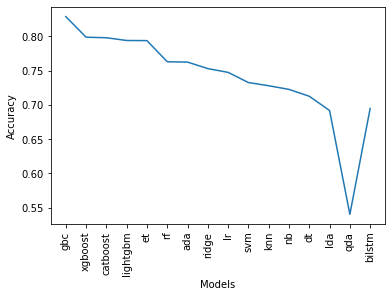

In [32]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}
fig, ax = plt.subplots()
figsize=(10,6)
ax.plot(results_df['ModelAbbrv'],results_df['Accuracy'])
plt.xticks(rotation=90)
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")

Text(0, 0.5, 'Recall')

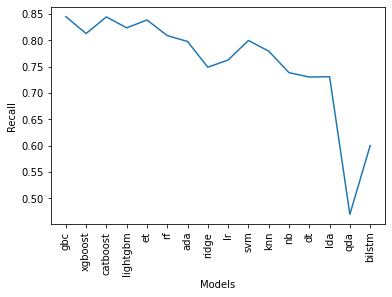

In [33]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}
fig, ax = plt.subplots()
figsize=(10,6)
ax.plot(results_df['ModelAbbrv'],results_df['Recall'])
plt.xticks(rotation=90)
ax.set_xlabel("Models")
ax.set_ylabel("Recall")

Text(0, 0.5, 'Precision')

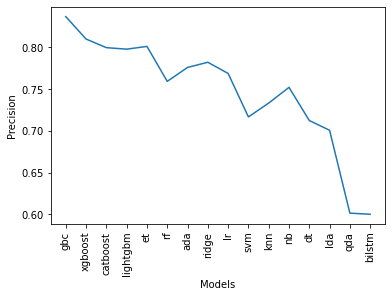

In [34]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}
fig, ax = plt.subplots()
figsize=(10,6)
ax.plot(results_df['ModelAbbrv'],results_df['Prec.'])
plt.xticks(rotation=90)
ax.set_xlabel("Models")
ax.set_ylabel("Precision")

Text(0, 0.5, 'F1_measure')

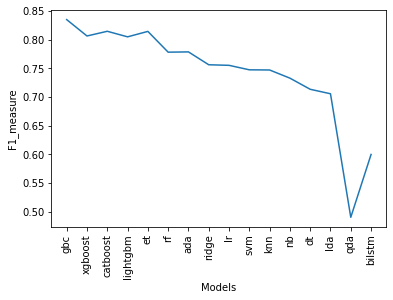

In [35]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}
fig, ax = plt.subplots()
figsize=(10,6)
ax.plot(results_df['ModelAbbrv'],results_df['F1'])
plt.xticks(rotation=90)
ax.set_xlabel("Models")
ax.set_ylabel("F1_measure")

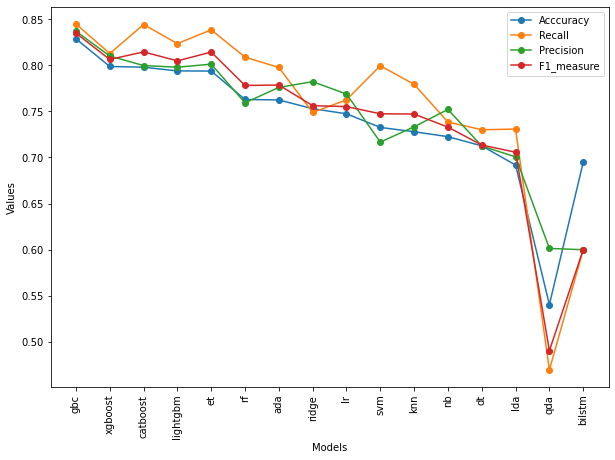

In [36]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 10}
fig, ax = plt.subplots()
#figsize=(10,6)
ax.plot(results_df['ModelAbbrv'],results_df['Accuracy'],label='Acccuracy', marker='o')
ax.plot(results_df['ModelAbbrv'],results_df['Recall'],label='Recall', marker='o')
ax.plot(results_df['ModelAbbrv'],results_df['Prec.'],label='Precision', marker='o')
ax.plot(results_df['ModelAbbrv'],results_df['F1'],label='F1_measure', marker='o')
plt.xticks(rotation=90)
ax.set_xlabel("Models")
plt.legend()
ax.set_ylabel("Values")
plt.gcf().set_size_inches(10, 7)
plt.savefig('lines.png', dpi=200)

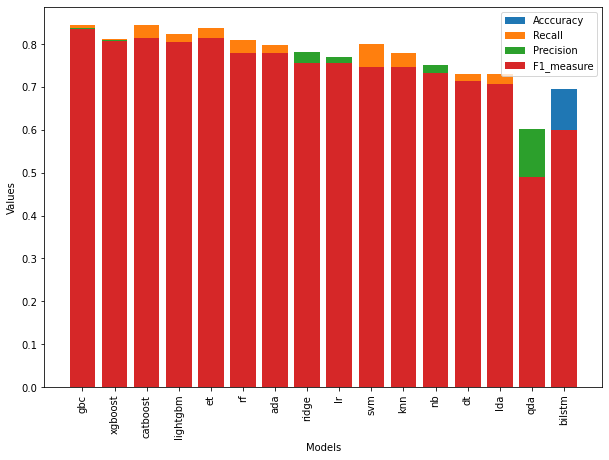

In [37]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 10}
fig, ax = plt.subplots()
#figsize=(10,6)
ax.bar(results_df['ModelAbbrv'],results_df['Accuracy'],label='Acccuracy')
ax.bar(results_df['ModelAbbrv'],results_df['Recall'],label='Recall')
ax.bar(results_df['ModelAbbrv'],results_df['Prec.'],label='Precision')
ax.bar(results_df['ModelAbbrv'],results_df['F1'],label='F1_measure')
plt.xticks(rotation=90)
ax.set_xlabel("Models")
plt.legend()
ax.set_ylabel("Values")
plt.gcf().set_size_inches(10, 7)
plt.savefig('lines.png', dpi=200)

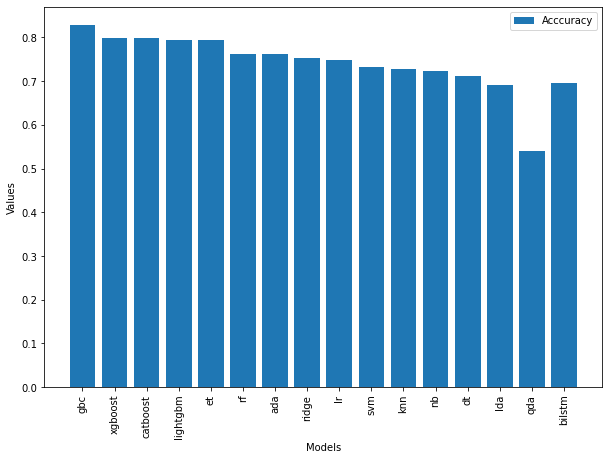

In [38]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 10}
fig, ax = plt.subplots()
#figsize=(10,6)
ax.bar(results_df['ModelAbbrv'],results_df['Accuracy'],label='Acccuracy')
plt.xticks(rotation=90)
ax.set_xlabel("Models")
plt.legend()
ax.set_ylabel("Values")
plt.gcf().set_size_inches(10, 7)
plt.savefig('bar_acc.png', dpi=200)

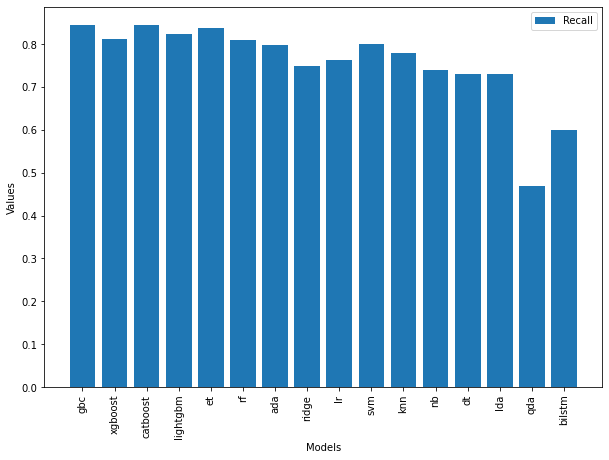

In [39]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 10}
fig, ax = plt.subplots()
#figsize=(10,6)
ax.bar(results_df['ModelAbbrv'],results_df['Recall'],label='Recall')
plt.xticks(rotation=90)
ax.set_xlabel("Models")
plt.legend()
ax.set_ylabel("Values")
plt.gcf().set_size_inches(10, 7)
plt.savefig('bar_rec.png', dpi=200)

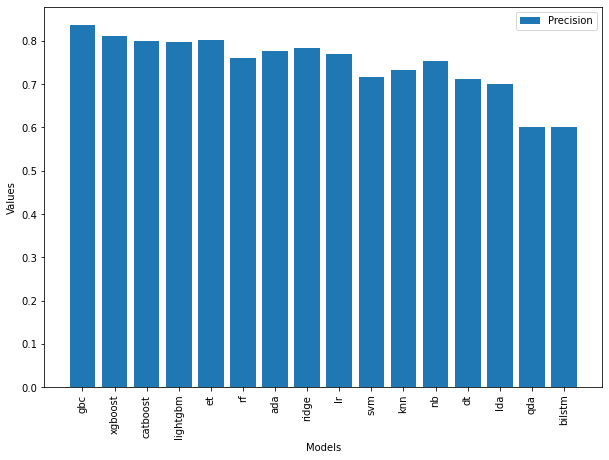

In [40]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 10}
fig, ax = plt.subplots()
#figsize=(10,6)
ax.bar(results_df['ModelAbbrv'],results_df['Prec.'],label='Precision')
plt.xticks(rotation=90)
ax.set_xlabel("Models")
plt.legend()
ax.set_ylabel("Values")
plt.gcf().set_size_inches(10, 7)
plt.savefig('bar_prec.png', dpi=200)

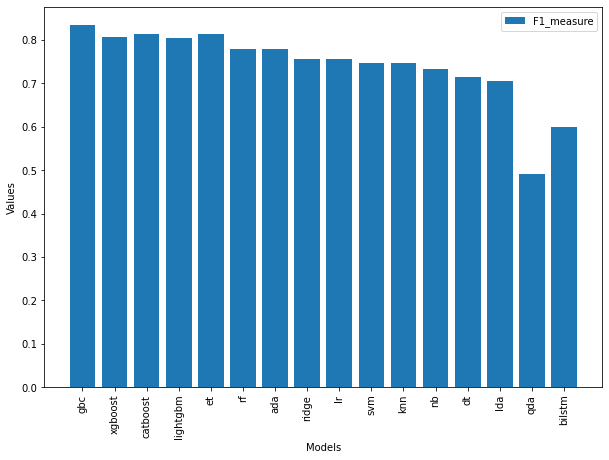

In [41]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 10}
fig, ax = plt.subplots()
#figsize=(10,6)
ax.bar(results_df['ModelAbbrv'],results_df['F1'],label='F1_measure')
plt.xticks(rotation=90)
ax.set_xlabel("Models")
plt.legend()
ax.set_ylabel("Values")
plt.gcf().set_size_inches(10, 7)
plt.savefig('bar_f1.png', dpi=200)

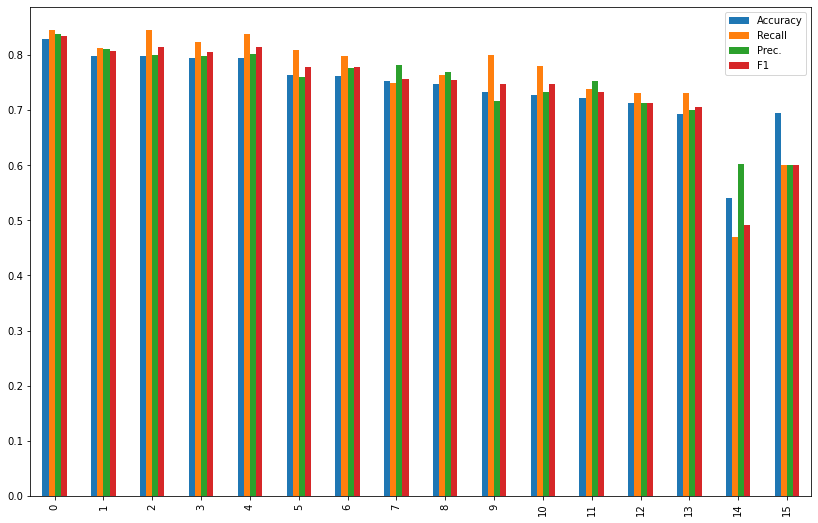

In [42]:
results_df.plot(kind="bar")
plt.xticks(rotation=90)
ax.set_xlabel("Models")
plt.legend()
ax.set_ylabel("Values")
plt.gcf().set_size_inches(14, 9)
plt.savefig('bars_paralel.png', dpi=200)

## Feature impact 

In [43]:
import shap
from sklearn.preprocessing import OneHotEncoder
from itertools import chain
from collections import defaultdict
shap.initjs()

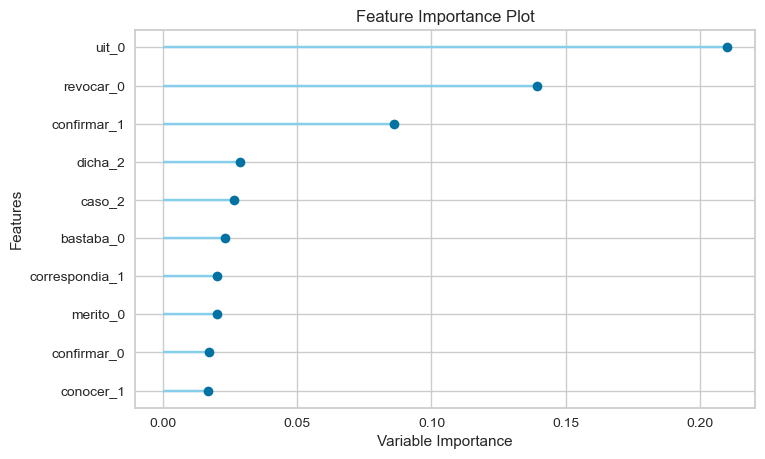

In [44]:
gbc = create_model('gbc')
plot_model(gbc, plot = 'feature')

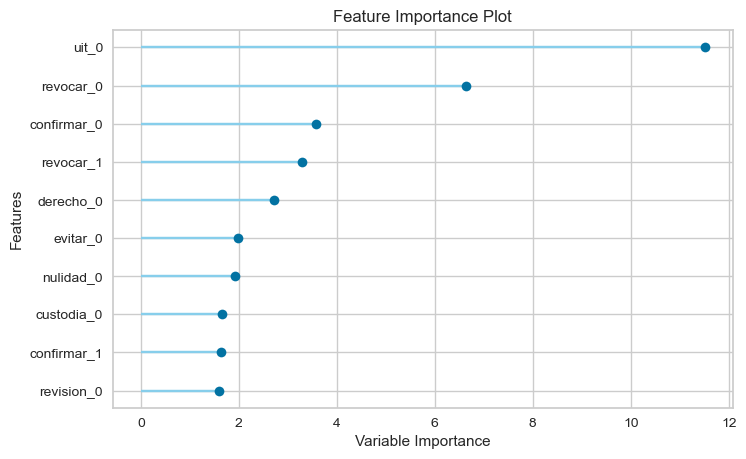

In [45]:
cat = create_model('catboost')
plot_model(cat, plot = 'feature')

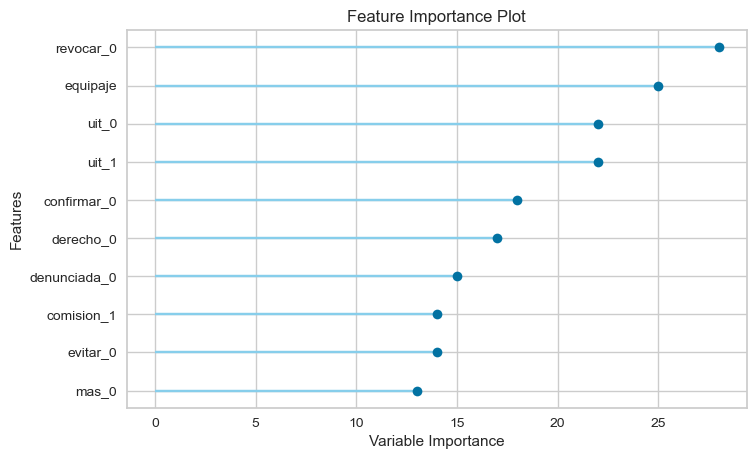

In [46]:
light = create_model('lightgbm')
plot_model(light, plot = 'feature')

In [47]:
#evaluate_model(cat)

## Shap evaluation with Pycaret

In [48]:
#save_model(best, 'best_model')
#saved_model = load_model('house_price_model')
cat

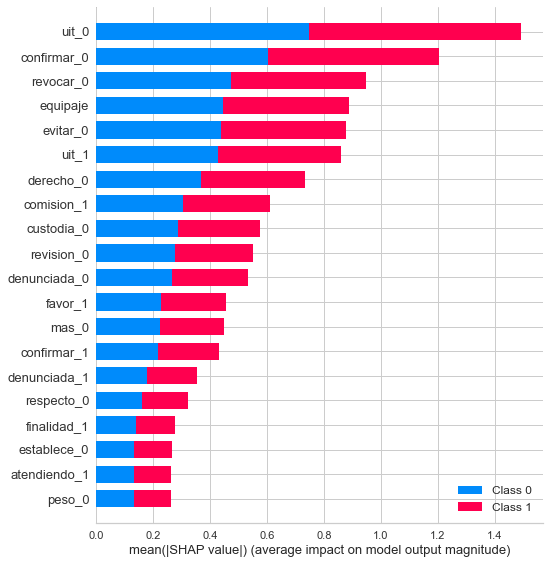

<Figure size 576x396 with 0 Axes>

In [49]:
interpret_model(light, plot = 'summary')
plt.savefig('shap1.png')

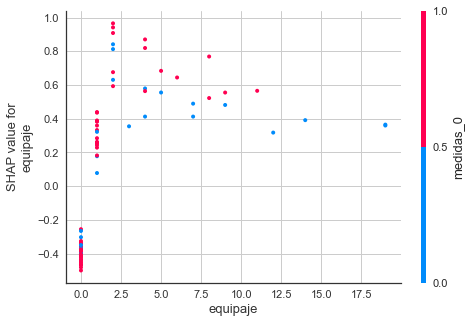

In [50]:
interpret_model(light, plot = 'correlation')

In [51]:
#interpret_model(cat, plot = 'reason')

In [52]:
print(BoW_df['uit'].unique)

<bound method Series.unique of 0      1
1      1
2      1
3      1
4      0
      ..
278    0
279    0
280    0
281    1
282    1
Name: uit, Length: 283, dtype: int64>


## Prediction

In [53]:
predict_model(light)
predictions = predict_model(cat, data=BoW_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8118,0.8622,0.8235,0.8571,0.8400,0.6117,0.6124


/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/utils/depreca

In [54]:
predictions[["Label", "Score"]]

,Label,Score
0,1,0.9063
1,1,0.8109
2,0,0.5565
3,1,0.9357
4,0,0.5817
...,...,...
278,1,0.5900
279,0,0.6915
280,1,0.7590
281,1,0.8843


In [55]:
corpus_class = pd.concat([corpus[["Texto","Decisión"]],predictions[["Label", "Score"]]], axis=1)

In [56]:
print(corpus_class.head(50))

                                                Texto  Decisión  Label   Score
0   Idoneidad del servicio empresa de transporte f...         1      1  0.9063
1   Idoneidad del servicio paredes estrella cargo ...         1      1  0.8109
2   Idoneidad del servicio gradacion de la sancion...         0      0  0.5565
3   Idoneidad del servicio empresa de transporte e...         1      1  0.9357
4   Idoneidad del servicio empresa de transportes ...         0      0  0.5817
5   Idoneidad del servicio empresa de transporte f...         1      1  0.9269
6   Idoneidad del servicio expreso grael sac el he...         0      0  0.8803
7   Idoneidad del servicio turismo civa sac el pro...         0      0  0.6646
8   Idoneidad del servicio transporte la marginal ...         1      1  0.9410
9   Idoneidad del servicio enlaces sa en la entreg...         1      1  0.9103
10  Idoneidad del servicio empresa de transportes ...         1      1  0.9447
11  Idoneidad del servicio movil tours sa en la en..

In [57]:
#corpus_class.to_csv('corpus_class.csv', index=False)

In [58]:
corpus_class.sample(n = 12, random_state = 2)

,Texto,Decisión,Label,Score
7,Idoneidad del servicio turismo civa sac el pro...,0,0,0.6646
231,Idoneidad del servicio transporte terrestre em...,0,0,0.5973
254,Idoneidad del servicio expreso internacional o...,0,0,0.9649
208,Recurso de revision improcedencia turismo civa...,0,0,0.9186
267,Idoneidad del servicio empresa de transporte t...,1,1,0.7157
101,Idoneidad del servicio expreso molina union ei...,1,1,0.9576
35,Idoneidad del servicio expreso internacional o...,1,1,0.9186
220,Idoneidad clausulas abusivas proteccion minima...,0,0,0.9163
3,Idoneidad del servicio empresa de transporte e...,1,1,0.9357
113,Idoneidad del servicio transportes cruz del su...,1,1,0.9206


## Shap evaluation with Sklearn

In [59]:
import shap
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

BoW_df_new = BoW_df.loc[:, BoW_df.columns != 'target_cat']
X_train, X_test = BoW_df_new[:250], BoW_df_new[250:]
y_train, y_test = BoW_df['target_cat'][:250], BoW_df['target_cat'][250:]

model = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

model.fit(X_train, y_train)

#shap.initjs()


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [60]:
#from catboost import CatBoostClassifier

#clf = CatBoostClassifier(iterations=5,learning_rate=0.1, loss_function='CrossEntropy')
#clf.fit(X_train, y_train)

In [61]:
#Get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

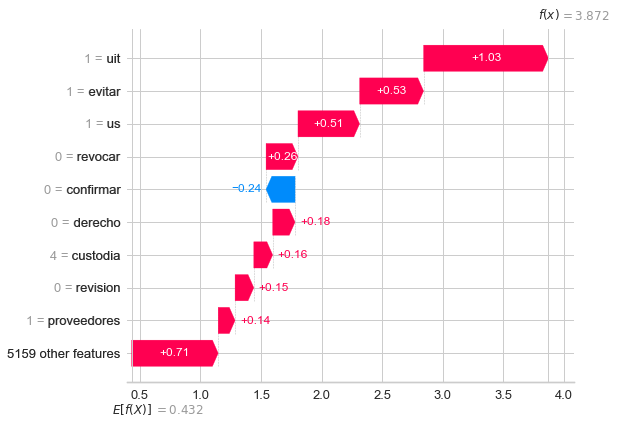

Idoneidad del servicio empresa de transporte flores hermanos srl la perdida del equipaje de pasajero durante viaje en autobus constituye riesgo tipico de la actividad realizada por la denunciada como proveedor del servicio de transporte terrestre la obligacion de transportar pasajeros impone ademas deber de custodia del equipaje transportado por la empresa de transporte hasta le sea entregado al usuario el deber de custodia recae en las empresas de transporte incluye justamente evitar la perdida extravio robo del equipaje transportan en tal sentido consumidor razonable al contratar servicio de transporte terrestre esperaria su equipaje sea transportado en forma adecuada diligente segura al destino correspondiente de forma tal le sea devuelto al final del viaje en las mismas condiciones en le fue entregado segun el deber de custodia le asiste en efecto el la perdida del equipaje se haya producido como consecuencia de error en la consignacion del lugar de destino en el boleto del equipaj

In [62]:
import matplotlib.pyplot as plt
from types import SimpleNamespace
indices_0 = [7, 231, 208, 235, 220]
indices_1 = [13, 101, 35, 3, 113]
index = 5
to_pass = SimpleNamespace(**{
                          'values': np.array(shap_values[index].values),
                          'data': np.array(shap_values[index].data),
                          'feature_names': X_train.columns,
                          'base_values': shap_values[index].base_values[0]
            })
shap.plots.waterfall(to_pass)
#plt.gcf().set_size_inches(8, 10)
#plt.tight_layout(pad=0.1)
#plt.savefig('ex_class_5.png', dpi=200)
print(corpus_class['Texto'][index])

In [63]:
# impacto de las variables para una instancia 
#shap.plots.waterfall(shap_values_bin[5])
#print(corpus['Texto'][5])

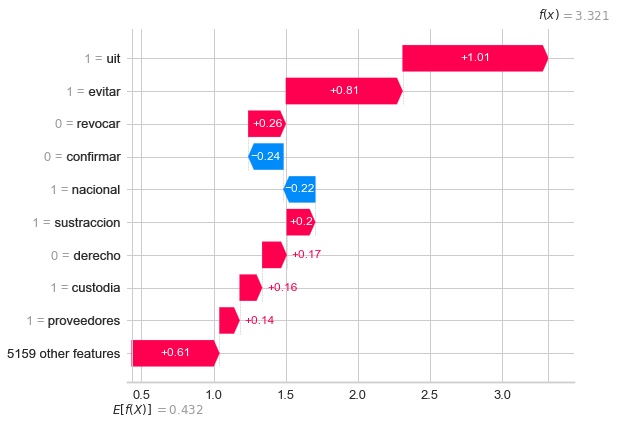

Idoneidad del servicio empresa de transporte flores hermanos srl la perdida del equipaje de pasajero durante viaje en autobus constituye riesgo tipico de la actividad realizada por la denunciada como proveedor del servicio de transporte terrestre la obligacion de transportar pasajeros impone ademas deber de custodia del equipaje transportado por la empresa de transporte hasta le sea entregado al usuario el deber de custodia recae en las empresas de transporte incluye justamente evitar la perdida extravio robo del equipaje transportan en tal sentido consumidor razonable al contratar servicio de transporte terrestre esperaria su equipaje sea transportado en forma adecuada diligente segura al destino correspondiente de forma tal le sea devuelto al final del viaje en las mismas condiciones en le fue entregado segun el deber de custodia le asiste en efecto el la perdida del equipaje se haya producido como consecuencia de error en la consignacion del lugar de destino en el boleto del equipaj

In [64]:
# impacto de las variables para una instancia 
from types import SimpleNamespace
to_pass = SimpleNamespace(**{
                          'values': np.array(shap_values[12].values),
                          'data': np.array(shap_values[12].data),
                          'feature_names': X_train.columns,
                          'base_values': shap_values[12].base_values[0]
            })
shap.plots.waterfall(to_pass)
print(corpus_class['Texto'][5])

In [65]:
shap.plots.force(shap_values[0])

In [66]:
shap.plots.force(shap_values[0])

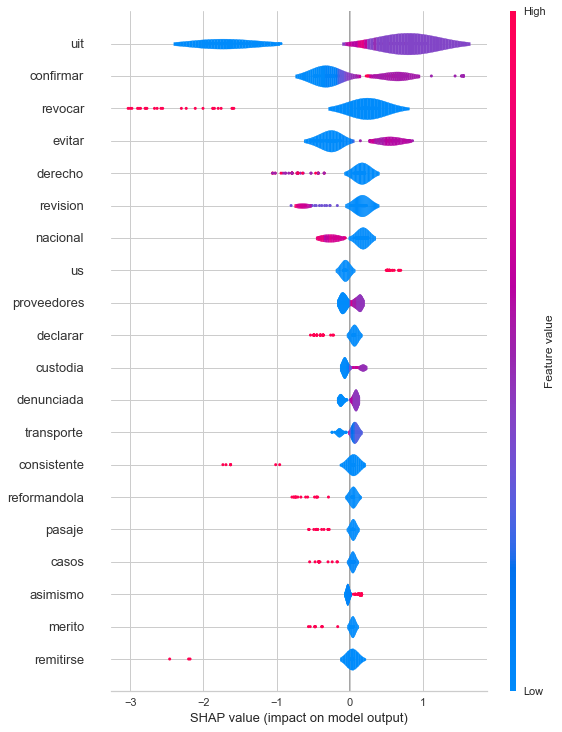

In [67]:
#shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, plot_type='violin',show=False)
plt.gcf().set_size_inches(8, 10)
plt.tight_layout(pad=0.1)
plt.savefig('img.png', dpi=200)

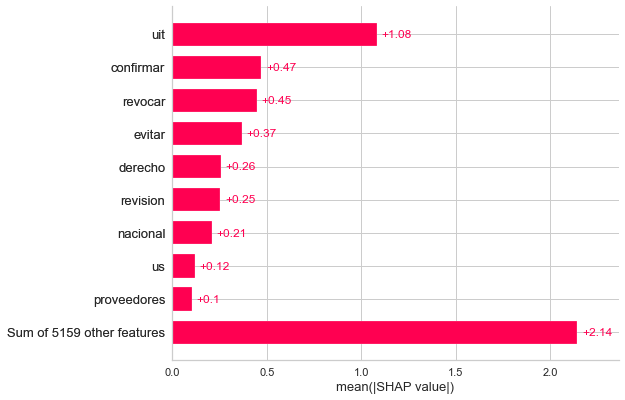

In [68]:
shap.plots.bar(shap_values)

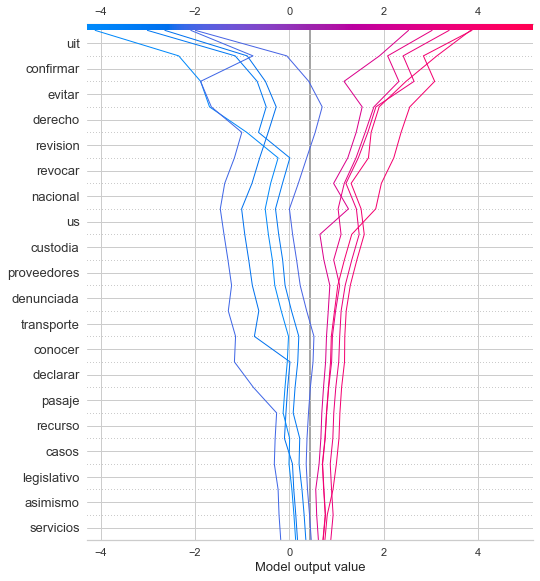

In [69]:
# Tree explainer
docs = [7,231,208,235,220,13,101,35,3,5]
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
features = X_train.iloc[range(250)]
shap_values_tree = explainer.shap_values(features)[docs]

shap.decision_plot(expected_value, shap_values_tree, BoW_df_new.columns)

## Shap values for individual features

In [70]:
#Get shap values
explainer = shap.Explainer(model)
shap_val_uq = explainer(X_train)

In [89]:
# give column name
col_name = "uit"
index_no = BoW_df_new.columns.get_loc(col_name)
index_no

4949

In [95]:
shap_val_uq

.values =
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

.base_values =
array([[0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553],
       [0.43160553]

In [72]:
feature_names = BoW_df_new.columns
shap_df_val = pd.DataFrame(shap_val_uq.values, columns=feature_names)#Change values by data for extract data from shap
shap_df_data = pd.DataFrame(shap_val_uq.data, columns=feature_names)
shap_df_data.head()

,aatc,abandonado,abandono,abanto,abierta,abierto,abonar,abonara,abone,abordaje,...,yurimaguas,zafra,zamora,zapatos,zarate,zelada,zolezzi,zona,zonas,zuniga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
list_shap_uit_val = shap_df_val.loc[:, 'uit'].tolist()
list_shap_uit_data = shap_df_data.loc[:, 'uit'].tolist()

In [74]:
list_shap_uit_val

[0.8184949543675862,
 0.960496827611308,
 0.9274975447374045,
 0.9423564627650604,
 -1.7645428039383124,
 1.0305989595569638,
 -1.9374060114194052,
 -1.9374882547845955,
 0.9938662121575027,
 0.9583227020563013,
 0.9961393644082271,
 0.9961393644082271,
 1.0108955274749247,
 0.9755370384525708,
 1.0131686797256492,
 0.9961393644082271,
 0.9742662575576749,
 1.0309967484989355,
 1.0305989595569638,
 0.9986891647643492,
 0.9943946450638337,
 0.9986891647643492,
 0.9946710284596175,
 0.9499290693305713,
 1.0134219770236457,
 1.010899978261418,
 -1.524153937553263,
 -1.818619488690346,
 1.031394916801698,
 1.0165558328506867,
 0.8174526288373506,
 0.9934832597369119,
 0.636644683210281,
 1.0342387047809463,
 0.832606118394083,
 0.6156962248108347,
 -1.2453300657729358,
 -1.604882014877521,
 0.6585647661927049,
 0.602939432807585,
 0.9823488298008949,
 0.9585477155265022,
 0.6520987065596389,
 0.6903689498775425,
 0.7073317985188748,
 -1.2179581763463405,
 0.7965970562878492,
 0.64945908962

In [75]:
#Get shaply values and feature values for odor
uit_values = np.array(list_shap_uit_val) 
uit_data = np.array(list_shap_uit_data) 

In [76]:
shap_df_data.loc[:, 'uit'].unique()

array([1, 0, 2, 3, 4, 5])

In [77]:
#get shaply values and data
uit_categories = [1, 0, 2, 3, 4, 5]

In [108]:
len(shap_values)

250

In [96]:
#Split uir SHAP values by unique uit categories
#new_shap_values = [np.array(pd.Series(uit_values)[uit_data==s])for s in uit_categories]

#Each sublist needs to be the same length
#max_len = max([len(v) for v in new_shap_values])
#new_shap_values = [np.append(vs,[np.nan]*(max_len - len(vs))) for vs in new_shap_values]
#new_shap_values = np.array(new_shap_values)

#transpost matrix so categories are columns and SHAP values are rows
#new_shap_values = new_shap_values.transpose()

#replace shap values
#shap_values_uit.values = np.array(new_shap_values)

#replace data with placeholder array
#shap_values_uit.data = np.array([[0]*len(uit_categories)]*max_len)

#replace base data with placeholder array
#shap_values_uit.base = np.array([0]*max_len)

#replace feature names with category labels
#shap_values_uit.feature_names = list(uit_categories)

#Use beeswarm as before
#shap.plots.beeswarm(shap_values_uit,color_bar=False)

In [113]:
#https://github.com/conorosully/medium-articles/blob/master/src/interpretable%20ml/SHAP/SHAP_catboost.ipynb

# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
len(shap_values)

250

In [118]:
#Create for placeholder SHAP values
shap_values_uit = explainer(X_train)

#Get shaply values and feature values for odor
uit_values = np.array(shap_values[4].values) 
uit_data = X_train['uit']

#Create new SHAP values array

#Split odor SHAP values by unique odor categories
unique_uit = uit_categories
new_shap_values = [np.array(pd.Series(uit_values)[uit_data==uit]) for uit in unique_uit]

#Each sublist needs to be the same length
max_len = max([len(v) for v in new_shap_values])
new_shap_values = [np.append(vs,[np.nan]*(max_len - len(vs))) for vs in new_shap_values]
new_shap_values = np.array(new_shap_values)

#transpost matrix so categories are columns and SHAP values are rows
new_shap_values = new_shap_values.transpose()

#replace shap values
shap_values_uit.values = np.array(new_shap_values)

#replace data with placeholder array
shap_values_uit.data = np.array([[0]*len(unique_uit)]*max_len)

#replace base data with placeholder array
shap_values_uit.base = np.array([0]*max_len)

#replace feature names with category labels
shap_values_uit.feature_names = list(uit_categories)

#Use besswarm as before
shap.plots.beeswarm(shap_values_uit,color_bar=False,show=False)

#plt.savefig(path.format('beeswarm_odor.png'),dpi=100,bbox_inches='tight', facecolor='white')

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [99]:
#Each sublist needs to be the same length
max_len = max([len(v) for v in shap_val_uq])
new_shap_values = [np.append(vs,[np.nan]*(max_len - len(vs))) for vs in shap_val_uq]
new_shap_values = np.array(new_shap_values)

In [100]:
new_shap_values = new_shap_values.transpose()

In [101]:
new_shap_values = np.array(new_shap_values)

In [102]:
new_shap_values = np.array([[0]*len(uit_categories)]*max_len)

In [103]:
new_shap_values.base = np.array([0]*max_len)

AttributeError: attribute 'base' of 'numpy.ndarray' objects is not writable

In [92]:
new_shap_values.feature_names = list(uit_categories)

AttributeError: 'numpy.ndarray' object has no attribute 'feature_names'

In [94]:
shap.plots.beeswarm(new_shap_values,color_bar=False)

UnboundLocalError: local variable 'values' referenced before assignment